## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import array
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Data preprocessing

### Read data

In [2]:
stock_intc = pd.read_csv('../../Dataset/INTC.csv')
stock_intc

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,45.959999,47.470001,45.770000,47.080002,41.343922,18774600
1,2019-01-03,46.150002,46.279999,44.389999,44.490002,39.069469,32267300
2,2019-01-04,45.840000,47.570000,45.540001,47.220001,41.466869,35447300
3,2019-01-07,47.099998,48.000000,46.750000,47.439999,41.660057,22736800
4,2019-01-08,47.799999,48.029999,46.779999,47.740002,41.923508,22749200
...,...,...,...,...,...,...,...
1046,2023-02-28,24.940001,25.120001,24.730000,24.930000,24.828327,50255300
1047,2023-03-01,25.030001,25.920000,24.969999,25.330000,25.226696,47823400
1048,2023-03-02,25.209999,26.299999,25.120001,26.200001,26.093149,48309300
1049,2023-03-03,26.200001,26.480000,26.010000,26.400000,26.292332,36744900


### Reset index

In [3]:
# Convert the 'Date' column to datetime format
stock_intc['Date'] = pd.to_datetime(stock_intc['Date'])

# Set the 'Date' column as the index value
stock_intc = stock_intc.set_index(pd.DatetimeIndex(stock_intc['Date'].values))

# Create new datafram with Date and Close
df_intc = pd.DataFrame(stock_intc, columns=['Close'])

### Data normalization

In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
df_intc = scaler.fit_transform(np.array(df_intc).reshape(-1,1))

### Data splitting

In [5]:
# Length
    # Train: 60%
    # Val: 20%
    # Test: 20%
train_size = int(len(df_intc) * 0.6)
val_size = int(len(df_intc) * 0.2)
test_size = len(df_intc) - train_size - val_size

In [6]:
# Get Data 
train_data = df_intc[:train_size]
val_data = df_intc[train_size:train_size+val_size]
test_data = df_intc[train_size+val_size:]

In [7]:
# Create dataset
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - time_step - 1):
		a = dataset[i:(i + time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [8]:
# Reshape into X=t,t+1,t+2..t+60 and Y=t+60
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [9]:
# Make input for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

## Model training and testing

In [10]:
# Define model
    # Pack the sequence of the inner layers
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape = (60, 1)))
model.add(LSTM(64, return_sequences=True))
    # Dropout: Avoid remembering too much information => disable part of the previous data
model.add(Dropout(0.2))
model.add(LSTM(64))
    # 1 Dense layer (dense): 1 unit provides predictive value
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [11]:
# Using earlystopping to prevent overfitting
earlystop = EarlyStopping(monitor='val_loss', patience=10)

In [12]:
# Training LSTM model
model.fit(X_train, y_train, validation_data=(X_val, yval), epochs = 100, batch_size = 64,verbose = 1,  callbacks=earlystop)

Epoch 1/100
9/9 [==============================] - 34s 1s/step - loss: 0.1639 - val_loss: 0.0062
Epoch 2/100
9/9 [==============================] - 3s 378ms/step - loss: 0.0268 - val_loss: 0.0030
Epoch 3/100
9/9 [==============================] - 3s 357ms/step - loss: 0.0129 - val_loss: 0.0061
Epoch 4/100
9/9 [==============================] - 3s 385ms/step - loss: 0.0100 - val_loss: 0.0044
Epoch 5/100
9/9 [==============================] - 4s 414ms/step - loss: 0.0088 - val_loss: 0.0058
Epoch 6/100
9/9 [==============================] - 4s 409ms/step - loss: 0.0079 - val_loss: 0.0043
Epoch 7/100
9/9 [==============================] - 3s 372ms/step - loss: 0.0085 - val_loss: 0.0051
Epoch 8/100
9/9 [==============================] - 3s 394ms/step - loss: 0.0083 - val_loss: 0.0058
Epoch 9/100
9/9 [==============================] - 3s 390ms/step - loss: 0.0078 - val_loss: 0.0038
Epoch 10/100
9/9 [==============================] - 4s 423ms/step - loss: 0.0074 - val_loss: 0.0049
Epoch 11/10

### Testing process

In [13]:
# Predict
    # Test
y_pred = model.predict(X_test)
    # Validation
y_pred_val = model.predict(X_val)

5/5 [==============================] - 1s 97ms/step


### Evaluate model

In [14]:
# Evaluate the accuracy of validation
val_mape = mean_absolute_percentage_error(y_pred_val, yval)
val_mse = mean_squared_error(y_pred_val, yval)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_pred_val, yval)

print(f"Validation MAPE: ", val_mape)
print(f"Validation RMSE: ", val_rmse)
print(f"Validation MSLE: ", val_msle)

Validation MAPE:  0.08428450173442201
Validation RMSE:  0.06291017516366276
Validation MSLE:  0.001598312612056457


In [15]:
# Evaluate the accuracy of test
test_mape = mean_absolute_percentage_error(y_pred, ytest)
test_mse = mean_squared_error(y_pred, ytest)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_pred, ytest)

print(f"Testing MAPE: ", test_mape)
print(f"Testing RMSE: ", test_rmse)
print(f"Testing MSLE: ", test_msle)

Testing MAPE:  0.5902195366872895
Testing RMSE:  0.13250354157667804
Testing MSLE:  0.013149660187965359


## Predicting the next 30 days

### Preparing the prediction data

In [16]:
x_input = val_data[5:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Define i
i = 0

# List storage value for next 30 days
prediction_next30_days = []

while(i < 30):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[-time_step:])

        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)

        temp_input.extend(y_hat[0].tolist())
        temp_input = temp_input[1:]

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose = 0)

        temp_input.extend(y_hat[0].tolist())

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1

In [17]:
# Print predict next 30 days
print(prediction_next30_days)

[[0.5489912629127502], [0.546288013458252], [0.544573962688446], [0.5439931154251099], [0.5445038080215454], [0.5459641218185425], [0.5481886863708496], [0.5509888529777527], [0.554192304611206], [0.557654857635498], [0.5612624287605286], [0.5649295449256897], [0.5685959458351135], [0.5722216367721558], [0.5757816433906555], [0.5792617797851562], [0.5826560854911804], [0.5859622359275818], [0.5891823172569275], [0.5923182368278503], [0.595373809337616], [0.5983521342277527], [0.6012564897537231], [0.6040894389152527], [0.6068534255027771], [0.6095502972602844], [0.6121816039085388], [0.614749014377594], [0.6172541975975037], [0.6196979284286499]]


### Preparing the forecast date index

In [18]:
# Get the last date from the current index
last_date = stock_intc.index.max()

# Create a list of indices starting from the next date for 30 days
future_dates = pd.date_range(start=pd.to_datetime(last_date) + pd.DateOffset(days=1), periods=30, freq='D')

In [19]:
# Convert from list to array
prediction_next30_days = np.array(prediction_next30_days)

# Convert to normal values from 0, 1
prediction_next30_days = scaler.inverse_transform(prediction_next30_days).reshape(-1)

In [20]:
# Convert to normal values
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)
val_data = scaler.inverse_transform(val_data)

## Visualization

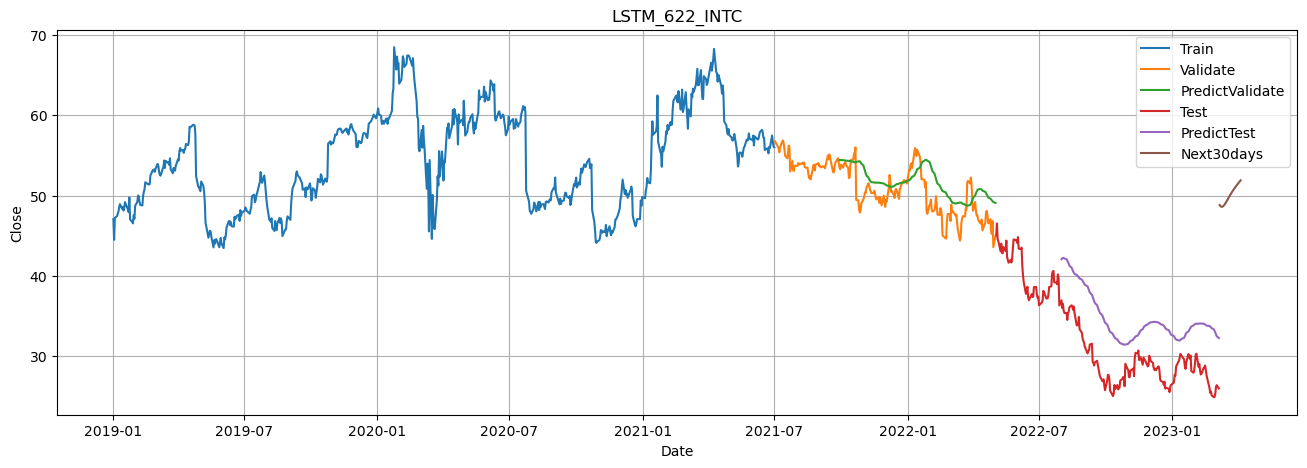

In [21]:
plt.figure(figsize=(16,5))

plt.plot(stock_intc.index[:train_size], train_data)

plt.plot(stock_intc.index[train_size:train_size + val_size],val_data)

plt.plot(stock_intc.index[train_size + time_step + 1: train_size + val_size],y_pred_val)

plt.plot(stock_intc.index[train_size + val_size: train_size + test_size + val_size], test_data)

plt.plot(stock_intc.index[train_size + val_size + time_step + 1: train_size + test_size + val_size],(y_pred))

plt.plot(future_dates, prediction_next30_days)

plt.xlabel('Date')
plt.ylabel('Close')
plt.title('LSTM_622_INTC')
plt.legend(['Train','Validate','PredictValidate','Test','PredictTest','Next30days'])
plt.grid()
plt.savefig('LSTM_622_INTC.png')
plt.show()